# Random Forest

## Start Spark Session

In [1]:
import boto3
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window

spark = SparkSession.builder \
    .appName("Inference") \
    .getOrCreate()

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Trying to create a Glue session for the kernel.
Session Type: etl
Session ID: 76798541-edd3-422d-a0aa-f614f31146e0
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
Waiting for session 76798541-edd3-422d-a0aa-f614f31146e0 to get into ready status...
Session 76798541-edd3-422d-a0aa-f614f31146e0 has been created.



In [4]:
%session_id 

Current active Session ID: 76798541-edd3-422d-a0aa-f614f31146e0


## Set up Model

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lag
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Load data
bucket_name = "crypto-marketdata-marketdatabucket-m13jkiz8o4p7"
btc_processed_file_path = "s3://{}/marketdata/processed_crypto/BTCUSDT-*-processed.parquet".format(bucket_name)

btc_processed_data = spark.read.parquet(btc_processed_file_path)
btc_processed_data = btc_processed_data.orderBy("close_time")

In [5]:
# Create the label (Next Close)
window = Window.orderBy("close_time")
btc_data_with_label = btc_processed_data.withColumn("Next_Close", F.lead("close").over(window))

In [6]:
# Drop rows with null values
btc_data_with_label = btc_data_with_label.dropna()

In [7]:
btc_data_with_label.columns

['close_time', 'open_time', 'open', 'high', 'low', 'close', 'vol', 'quote_asset_vol', 'number_of_trades', 'taker_base_asset_vol', 'taker_quote_asset_vol', 'ignore', 'ticker', 'SMA_240', 'SMA_480', 'RSI', 'Middle_Band', 'STD', 'Upper_Band', 'Lower_Band', 'Next_Close']


#### Train the model

In [8]:
# Prepare features and label

features = ['open', 'high', 'low', 'vol', 'quote_asset_vol', 
            'number_of_trades', 'taker_base_asset_vol', 
            'taker_quote_asset_vol', 'SMA_240', 'SMA_480', 'RSI', 
            'Middle_Band', "STD", "Upper_Band", "Lower_Band"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(btc_data_with_label).select("close_time", "features", "Next_Close")

In [9]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=4651)

In [10]:
# Create and train the Random Forest model
rf = RandomForestRegressor(labelCol="Next_Close", numTrees=100)
rf_model = rf.fit(train_data)

In [12]:
predictions = rf_model.transform(test_data)

In [13]:
predictions.select("Next_Close", "prediction").show()

+----------+------------------+
|Next_Close|        prediction|
+----------+------------------+
|  13780.41|12375.219159094202|
|  13499.99|12375.219159094202|
|   13022.0|12337.204945319978|
|   13135.0|12337.204945319978|
|  13240.37|12337.204945319978|
|  13399.24| 12351.20080932847|
|   13522.0|12389.117914833161|
|  14818.49| 15812.00906149773|
|  15019.66| 15812.00906149773|
|  14455.55| 15812.00906149773|
|  14855.02| 15812.00906149773|
|  15010.06| 15812.00906149773|
|  14700.01| 15812.00906149773|
|  14926.01| 15812.00906149773|
|  15119.97| 15812.00906149773|
|   14875.1| 15812.00906149773|
|  14353.01|13597.669534786814|
|  14648.89| 12693.39987858388|
|  14906.01|16054.184965367482|
|  14965.37|16054.184965367482|
+----------+------------------+
only showing top 20 rows


#### Result evaluation

In [14]:
# Evaluate the predictions
evaluator = RegressionEvaluator(labelCol="Next_Close", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE):", rmse)
print("R2:", r2)

Root Mean Squared Error (RMSE): 719.8483708500964
R2: 0.9986895989939096


#### Observe the feature importance

In [15]:
# Get feature importances
feature_importances = rf_model.featureImportances

# Create a list of feature names and their corresponding coefficients
feature_names = features
results = [(feature_names[i], feature_importances[i]) for i in range(len(feature_importances))]

for feature, importance in results:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: open, Importance: 0.18706680951567084
Feature: high, Importance: 0.3696780443960702
Feature: low, Importance: 0.25230390668459507
Feature: vol, Importance: 1.1106734942052426e-07
Feature: quote_asset_vol, Importance: 0.0004661795386431292
Feature: number_of_trades, Importance: 6.552643238732314e-06
Feature: taker_base_asset_vol, Importance: 3.6040365835381086e-06
Feature: taker_quote_asset_vol, Importance: 2.1693361299058173e-06
Feature: SMA_240, Importance: 0.06543665488170879
Feature: SMA_480, Importance: 0.07082636363391556
Feature: RSI, Importance: 0.00010819686041491067
Feature: Middle_Band, Importance: 0.031623438098106985
Feature: STD, Importance: 7.254780565001668e-05
Feature: Upper_Band, Importance: 0.0191236654237036
Feature: Lower_Band, Importance: 0.0032817560782193765


#### Plot the prediction vs actual close price

In [16]:
predictions_pd = predictions.toPandas()

In [17]:
predictions_pd.tail(1)

                   close_time  ...    prediction
11836 2024-10-31 22:59:59.999  ...  68925.274492

[1 rows x 4 columns]


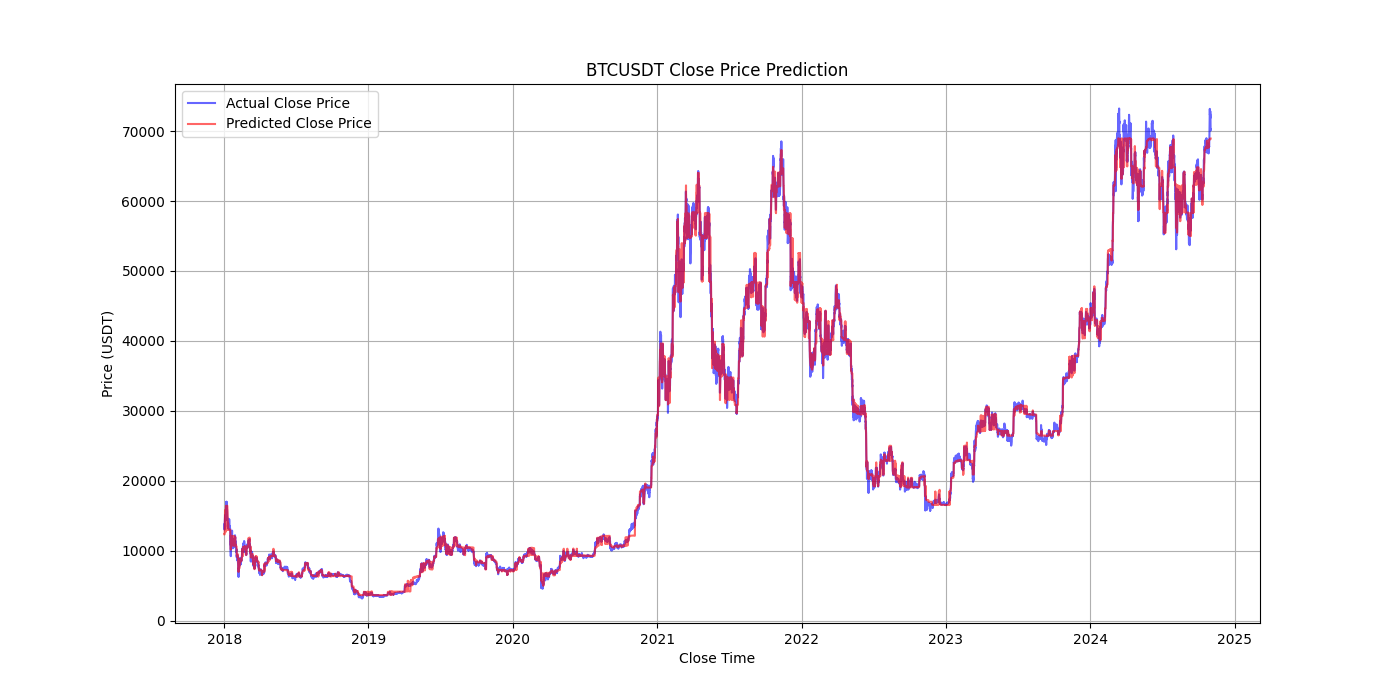

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(predictions_pd["close_time"], predictions_pd["Next_Close"].values, label="Actual Close Price", color="blue", alpha=0.6)
plt.plot(predictions_pd["close_time"], predictions_pd["prediction"].values, label="Predicted Close Price", color="red", alpha=0.6)
plt.title("BTCUSDT Close Price Prediction")
plt.xlabel("Close Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid()
plt.show()

%matplot plt

In [6]:
%stop_session

Stopping session: 76798541-edd3-422d-a0aa-f614f31146e0
Stopped session.
